# Monosynaptic pair analysis
-------

Example notebook demonstrating simple functions in SynapticConn for plotting spike trains. 

In [1]:
import os
import pathlib

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

os.chdir('../..')
print(os.getcwd())

from synapticonn.plots import plot_acg, plot_ccg
from synapticonn.postprocessing import compute_crosscorrelogram, compute_autocorrelogram
from synapticonn.analysis.synaptic_strength import calculate_synaptic_strength

import synapticonn as synapticonn

/Users/michael.zabolocki/Desktop/code/SynaptiConn


Load data. 

In [2]:
data_fpath = pathlib.Path('tests', 'BD0187_spikesorting_array.pkl')

# open pickle
all_units = np.load(data_fpath, allow_pickle=True)
all_units = all_units['spike_time_set']
# spike_train_1 = all_units[0]/30_000  # unit 0
# spike_train_2 = all_units[1]/30_000  # unit 1

Set parameters.

In [3]:
srate = 30_000
bin_size_ms = 0.5
max_lag_ms = 25

Initialize the object.

In [4]:
snc = synapticonn.SynaptiConn(all_units, bin_size_ms=1, max_lag_ms=100, srate=30_000, recording_length=600)

Check the loaded spike units.

In [5]:
spk_unit_report = snc.report_spike_units()
pd.DataFrame(spk_unit_report)

,unit_id,n_spikes
0,5,302
1,1,1152
2,0,918
3,16,524
4,17,315
5,18,195
6,15,192
7,4,299
8,3,277


## Auto-correlograms
---

Compute the autocorrelogram for select unit IDs.

Plotting autocorrelogram for spike units: [3 1]


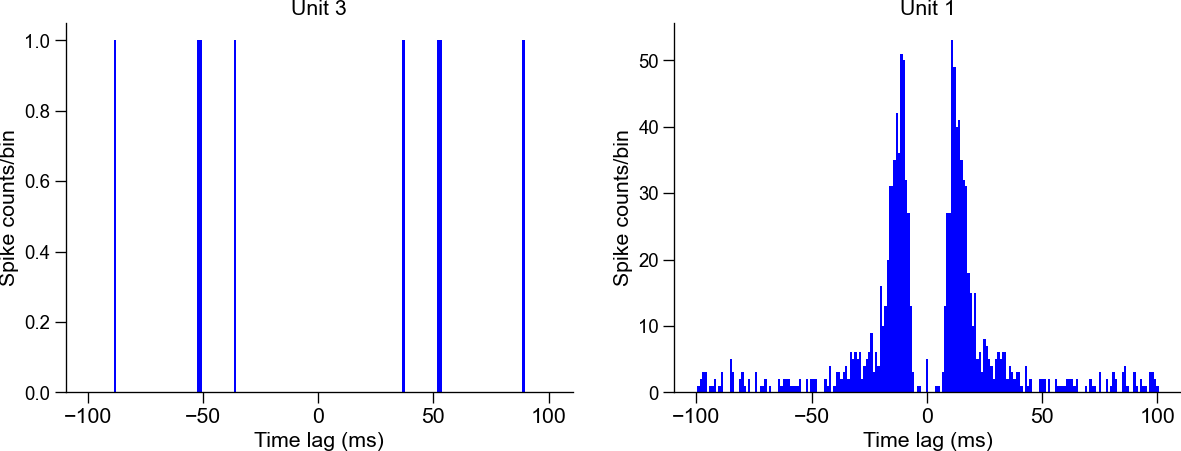

In [6]:
snc.plot_autocorrelogram(spike_units=[3,1,100], color='blue')

Set the bin parameters after initialization, and re-plot.

This can be used to change the binning on the plots, and max time lags.

Plotting autocorrelogram for spike units: [0 1]


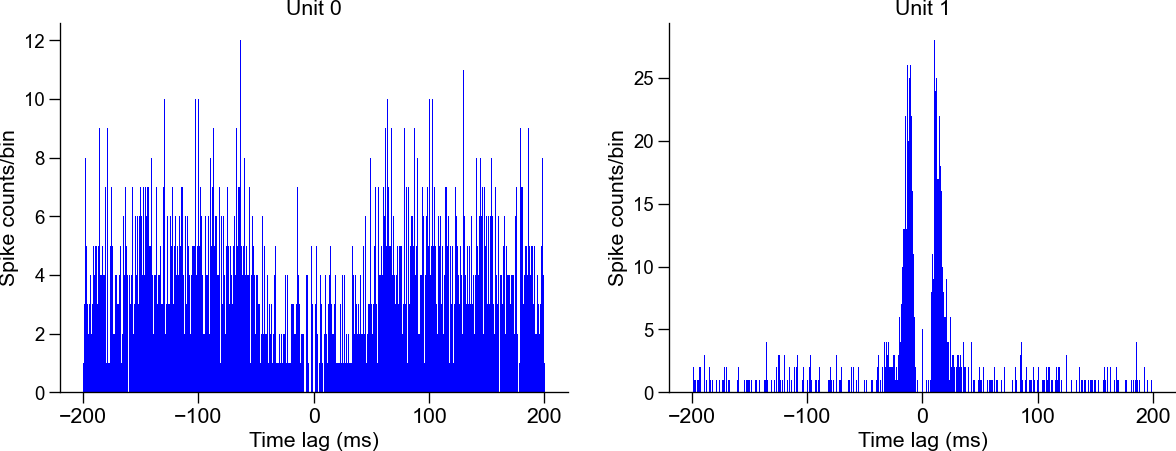

In [7]:
snc.set_bin_settings(bin_size_ms=0.5, max_lag_ms=200)
snc.plot_autocorrelogram(spike_units=[0,1], color='blue')

## Cross-correlograms
----

[(0, 1), (1, 5), (1, 16)]


KeyError: '(0, 1)'

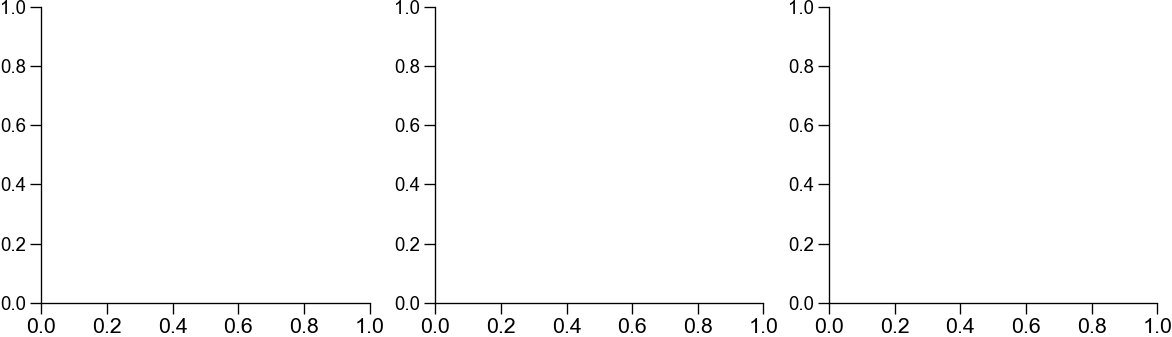

In [8]:
spike_pairs = [(1,16), (1,5), (0,1), (1,16)]
snc.plot_crosscorrelogram(spike_pairs=spike_pairs, figsize=(15, 4))

Alternatively, all possible pairs can be plotted.

In [ ]:
# spike_labels = snc.get_spike_unit_labels()

# # get all possible pairs between labels as tuples (including self-pairs)
# spike_pairs = [(i, j) for i in spike_labels for j in spike_labels]
# snc.plot_crosscorrelogram(spike_pairs=spike_pairs, figsize=(20, 30))

## Return correlogram data
----

Next, return the correlogram data.

Each key in 'cross_correlations' is indexed by the unit pairs. The corresponding numbers refer to the spike counts, per bin.

Each key in 'bins' is also indexed by the unit pairs. The corresponding numbers refer to the bins edges.

In [ ]:
correlogram_data = snc.return_crosscorrelogram_data(spike_pairs=spike_pairs)
correlogram_data

Check the bin settings using for correlogram generations.

In [ ]:
snc.report_correlogram_settings()

## Compute monosynaptic connections 
----

Compute excitatory and inhibitory monosynaptic connections between spike trains. 

This analysis was based on the following reference by Najafi et al., [here](https://www.sciencedirect.com/science/article/pii/S0896627319308487).

In [ ]:
neuron1_spike_train = [383.4, 423.7, 437.6, 544.9, 548.8, 602.8, 645.9, 715.2, 891.8, 963.7, 800, 500, 500.1]
neuron2_spike_train = [388.4, 428.7, 442.6, 549.9, 553.8, 607.8, 650.9, 720.2, 896.8, 968.7, 500.05, 500.15]

synaptic_strength_data = calculate_synaptic_strength(neuron1_spike_train, neuron2_spike_train,
                                                     num_iterations=1000, max_lag_ms=25,
                                                     bin_size_ms=0.5, jitter_range_ms=10)

Inspect the output synaptic strength data.

Note that the output contains the following keys: 
1. ccg bins
2. ccg counts (from original spike trains)
3. ccg counts (post jitter)
4. synaptic strength
5. high confidence interval (99%)
6. low confidence interval (1%)

In [ ]:
synaptic_strength = synaptic_strength_data['synaptic_strength']
print(f'Synaptic strength value: {synaptic_strength}')

Compute synaptic strength for set paris of neuron IDs.

In [ ]:
spike_pairs  # need a warning to list the pairs that are not valid

In [ ]:
synaptic_strength = {}
for pre_synaptic_neuron_id, post_synaptic_neuron_id in spike_pairs:

    pre_synaptic_spktimes = snc.get_spike_times_for_units([pre_synaptic_neuron_id]).get(pre_synaptic_neuron_id)
    post_synaptic_spktimes = snc.get_spike_times_for_units([post_synaptic_neuron_id]).get(post_synaptic_neuron_id)
    
    synaptic_strength_data = calculate_synaptic_strength(
        pre_synaptic_spktimes, post_synaptic_spktimes, num_iterations=1000,
        max_lag_ms=25, bin_size_ms=0.5, jitter_range_ms=10)

    synaptic_strength[(pre_synaptic_neuron_id, post_synaptic_neuron_id)] = synaptic_strength_data

In [ ]:
synaptic_strength[spike_pairs[0]]

TO DO: 

- Make an option to improve the CCG accuracy by checking firing rates etc. etc. etc.

In [ ]:
correlogram_data = snc.return_crosscorrelogram_data(spike_pairs=spike_pairs)
correlogram_data['cross_correllations']

## TO DO:
-----

- Plot all the data out

- Make an option to add new data -- therefore clearing the previous data here

- Check this analysis with a DANDI dataset

- Make a simulation model for ccgs and times etc. etc. to test these parameters

- Return ACG data

- Test units

- Style is not being fitted globally --> the decorator is useless?

- Document all the steps in place to check this all out ...

- Option to improve the labels here for the units? Check it with different input types

- Build a core object which allows for batch-processing, but also adds in the srates etc. of the recordings

- Option to cross-check with the distances???

- Option to change individual colors for CCGs?

- Merge the CCG and ACG decorators into one?

- For autocorrelograms:
    - ensure that the input is a list type 
    - add a function to check the lags and the bins for this etc.
    - check whether unit ids can be in str format etc.

- Plot_ccg is computing and then plotssing --> should be separate?

- Analysis for CCG and ACG should be separated?

- Check the CCG binning --> test this!

- Check the type hinting / remove these?